In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#define constants
n = 64
os = 1
osigma2 = 1

#load data
train = np.loadtxt('hw6_q2_train.csv', delimiter=",", dtype=float)
test = np.loadtxt('hw6_q2_test.csv', delimiter=",", dtype=float)

In [3]:
#function that computes kernel
def kernel(x,xp,s):
    k = np.e**(-(1 / (2 * s**2)) * (x - xp)**2)
    return k

#define a function to "fill" a matrix with kernel values to make life easier, only works for vector size of 1
def mkernel(x,xp,s):
    
    x1v, x2v = np.meshgrid(x,xp)
    
    k = kernel(x1v,x2v,s)
    
    return k.T

#function that computes kernels for GPR
def gpr(x_train, x_test, y_train, s, sigma_2):
    mean = mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train,x_train,s) 
                                                         + sigma_2 * np.eye(len(x_train))) @ (y_train - 0)
    covariance = mkernel(x_test, x_test, s) - mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train, x_train, s) 
                                                                                            + sigma_2 * np.eye(len(x_train))) @ mkernel(x_train, x_test, s)
    return mean, covariance

In [4]:
#split training data into x and y 
x_train = train[:,0]
y_train = train[:,1]

#split testing data into x and y
x_test = test[:,0]
y_test = test[:,1]

In [265]:
#compute predictions
x_values = np.linspace(-5,5,100)
mean, covariance = gpr(x_train, x_values, y_train, os, osigma2)

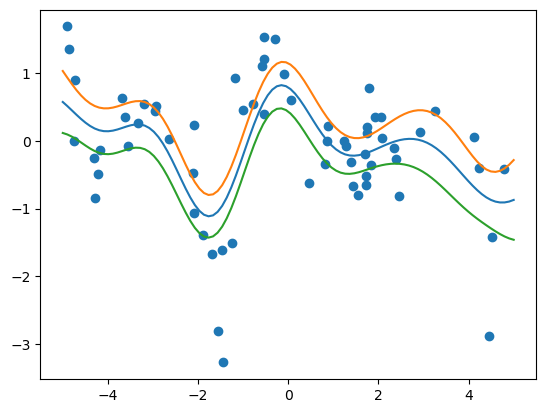

In [266]:
plt.scatter(x_train, y_train) 
plt.plot(x_values, mean)
plt.plot(x_values, mean + np.sqrt(np.diag(covariance)))
plt.plot(x_values, mean - np.sqrt(np.diag(covariance)))

In [7]:
def NLL(x, y, s, sigma2):
    n = np.size(x)
    C = mkernel(x, x, s) + sigma2 * np.identity(n)
    lp = (1 / 2) * y.T @ np.linalg.inv(C) @ y + np.log(np.linalg.det(C)) + n * np.log(2 * np.pi)
    return lp

def grad_NLL(x, y, s, sigma2):
    n = np.size(x)
    x1v, x2v = np.meshgrid(x,x)
    C = mkernel(x, x, s) + sigma2 * np.identity(n)
    dC_ds = (x1v - x2v)**2 * C / s**3
    dC_sigma2 = np.identity(n)
    
    C_inv = np.linalg.inv(C)
    alpha = C_inv @ y
    
    d_s = 1 / 2 * (np.trace(C_inv @ dC_ds) -  y.T @ C_inv @ dC_ds @ C_inv @ y)
    d_sigma2 = 1 / 2 * (np.trace(C_inv @ dC_sigma2) - y.T @ C_inv @ dC_sigma2 @ C_inv @ y)
    
    return d_s, d_sigma2

In [329]:
steps = 5000

lr = 0.001
s = 1
sigma2 = 1
best = 1000

for i in range(steps):
    d_s, d_sigma2 = grad_NLL(x_train, y_train, s, sigma2)
    
    s = s - lr * d_s
    sigma2 = sigma2 - lr * d_sigma2
    
    NLLn = NLL(x_train, y_train, s, sigma2)
    
    best = min(best, NLLn)
print(s,sigma2)

0.29212115840760977 0.2509776389669685


In [448]:
best

112.31994939698757

In [334]:
#compute new predictions
tmean, tcov = gpr(x_train, x_test, y_train, s, sigma2)

#compute predictions on uniform grid
x_values = np.linspace(-5,5,100)
tvmean, tvcov = gpr(x_train, x_values, y_train, s, sigma2)

#compute predictions with old constants
omean, ocov = gpr(x_train, x_test, y_train, os, osigma2)

In [337]:
#evaluate testing MSE
MSE1 = np.sum((tmean - y_test)**2)

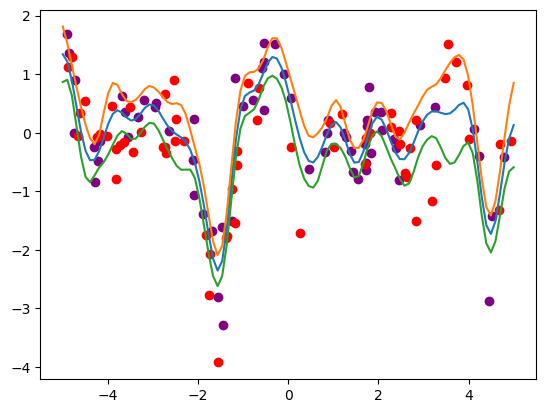

In [442]:
#plot new fit
plt.scatter(x_train, y_train, color = "purple") 
plt.scatter(x_test, y_test,color = "red") 
plt.plot(x_values, tvmean)
plt.plot(x_values, tvmean + np.sqrt(np.diag(tvcov)))
plt.plot(x_values, tvmean - np.sqrt(np.diag(tvcov)))

In [443]:
MSE1 = np.sum((tmean - y_test)**2)
MSE2 = np.sum((omean - y_test)**2)

In [449]:
MSE1

25.249346751442925

In [331]:
nx = 100
s_values = np.linspace(0.01,0.5,nx)
sigma_values = np.linspace(0.03,0.5,nx)
s_v, s2_v = np.meshgrid(s_values, sigma_values)
mNLL = np.zeros((len(s_values),len(sigma_values)))

for i in range(nx):
    for j in range(nx):
        mNLL[i,j] = NLL(x_train, y_train, s_v[i,j],s2_v[i,j])

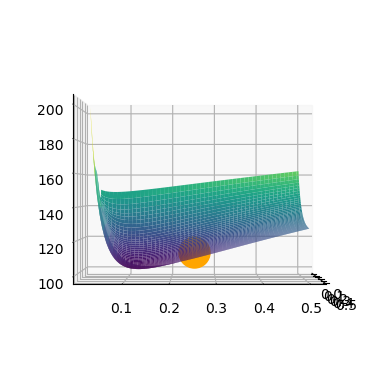

In [463]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(s,sigma2, best, s=500, color="orange")
surf = ax.plot_surface(s_v, s2_v, mNLL, cmap=cm.viridis,linewidth=0)
ax.view_init(0, 0)

In [486]:
steps = 1000

lr = 0.00001
ns = 0.4
nsigma2 = 0.1
nbest = 1000

for i in range(steps):
    d_s, d_sigma2 = grad_NLL(x_train, y_train, ns, nsigma2)
    
    ns = ns - lr * d_s
    nsigma2 = nsigma2 - lr * d_sigma2
    
    nNLLn = NLL(x_train, y_train, ns, nsigma2)
    
    nbest = min(nbest, nNLLn)
    
    if nbest == nNLLn:
        nsbest = ns
        nsigma2best = nsigma2
    
print(nsbest,nsigma2best)

0.39131463114080717 0.13264779777251032


(32.42735733815112, -42.54407911888151)